## Configuration

In [18]:
import pandas as pd
import numpy as np
from prophet import Prophet
from datetime import datetime

In [19]:
from src.widgets import get_config_widgets, select_features
from src.dataset import get_datasets, normalize_data
from src.feature import create_features, split
from src.prediction import linear_regression, predict_mse, predict_mae, calculate_error_metrics
from src.plot import plot_price_split, feature_importance, plot_predicted

from src.scraping import update_e_mix_data, update_e_price_data
from src.benchmark import extend_by_predictions_and_samples

In [20]:
# update_e_price_data()
# update_e_mix_data()

In [21]:
price_interval, prediction_date_picker, eval_size, normalize =  get_config_widgets()

IntRangeSlider(value=(-500, 900), continuous_update=False, description='Energy Price Interval', max=900, min=-…

DatePicker(value=datetime.date(2025, 2, 1), description='Prediction Date', step=1)

FloatSlider(value=0.05, description='Evaluation Set Size', max=0.2, step=0.01)

Checkbox(value=False, description='Normalize')

## Data loading

In [22]:
merged_df, e_price_df = get_datasets(prediction_date_picker.value)

Loading E-Prices
Last E-Price from: 2025-02-01 23:00:00
                      Price
Datetime                   
2018-10-01 00:00:00   59.53
2018-10-01 01:00:00   56.10
2018-10-01 02:00:00   51.41
2018-10-01 03:00:00   47.38
2018-10-01 04:00:00   47.59
...                     ...
2025-02-01 19:00:00  162.98
2025-02-01 20:00:00  156.60
2025-02-01 21:00:00  145.24
2025-02-01 22:00:00  141.73
2025-02-01 23:00:00  131.74

[55554 rows x 1 columns]
-----------------
Last energy mix from: 2025-01-31 00:00:00
                     Biomass  Hard Coal  Hydro  Lignite  Natural Gas  Nuclear   
Datetime                                                                        
2018-01-01 00:00:00    5.299      1.443  2.332    7.059        7.019    5.881  \
2018-01-01 01:00:00    5.283      1.425  2.191    7.149        7.108    4.776   
2018-01-01 02:00:00    5.285      1.485  2.186    7.103        7.164    4.612   
2018-01-01 03:00:00    5.290      1.469  2.168    7.059        7.267    4.911   
2018-01-

In [23]:
merged_df.to_csv("../data/merged.csv", index=True, na_rep='NaN')

## Feature Selection

### Best Feature Set (Prophet) - RMSE 7,02
- dayofweek
- dayofyear,
- ma_2_hours
- ma_3_hours
- ma_4_hours
- ma_16_hours
- ma_19_hours
- ma_20_hours
- ma_21_hours
- ma_22_hours
- ma_23_hours,
- Hydro
- Solar
- temperature_2m
- Precipitation (rain/snow)
- direct_radiation
### Best Feature Set (XGBoost)
- hour
- dayofweek
- dayofyear
- ma_3_hours 
- ma_6_hours
- ma_1_days
- ma_7_days 
- Biomass
- Hard Coal
- Hydro
- Lignite
- Natural Gas 
- Nuclear
- Other
- Pumped storage generation
- Solar
- Wind offshore
- Wind onshore
- pumped_storage_generation_ma_3_hours
- pumped_storage_generation_ma_6_hours

In [24]:
get_features, default_features = select_features()

Output()

Button(description='Confirm Selection', style=ButtonStyle())

In [25]:
# RERUN WHEN TICKING the NORMALIZED BOX 

selected_features = get_features()
FEATURES = default_features if not selected_features else selected_features

min_price, max_price = price_interval.value

features_df = create_features(merged_df.copy())
features_interval_df = features_df.copy()[
    (features_df["Price"] >= min_price) &
    (features_df["Price"] <= max_price)
]

normalized_features_df, normalized_e_price_df, normalized_interval_df, e_price_scaler = normalize_data(features_df.copy(), e_price_df.copy(), features_interval_df.copy())

TARGET = merged_df["Price"]
TARGET_INTERVAL = features_interval_df["Price"]
TARGET_NORMALIZED = normalized_features_df["Price"]
TARGET_NORMALIZED_INTERVAL = normalized_interval_df["Price"]

combined_df = pd.concat([features_df[FEATURES], TARGET], axis=1)
combined_interval_df = pd.concat([features_interval_df[FEATURES], TARGET_INTERVAL], axis=1)
combined_normalized_df = pd.concat([normalized_features_df[FEATURES], TARGET_NORMALIZED], axis=1)
combined_normalized_interval_df = pd.concat([normalized_interval_df[FEATURES], TARGET_NORMALIZED_INTERVAL], axis=1)


if normalize.value:
    train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST = split(combined_normalized_df,eval_size.value)
    train_XGB, eval_XGB, test_XGB, SPLIT_DATE_EVAL_INTERVAL, SPLIT_DATE_TEST_INTERVAL = split(combined_normalized_interval_df,eval_size.value)
    scalar = e_price_scaler
    
else:
    train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST = split(combined_df.copy(),eval_size.value)
    train_XGB, eval_XGB, test_XGB, SPLIT_DATE_EVAL_INTERVAL, SPLIT_DATE_TEST_INTERVAL = split(combined_interval_df,eval_size.value)
    scalar = None

TARGET = "Price"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

X_val = eval[FEATURES]
y_val = eval[TARGET]

X_train_XGB = train_XGB[FEATURES]
y_train_XGB = train_XGB[TARGET]

X_test_XGB = test_XGB[FEATURES]
y_test_XGB = test_XGB[TARGET]

X_val_XGB = eval_XGB[FEATURES]
y_val_XGB = eval_XGB[TARGET]



2024-12-30
2024-12-30


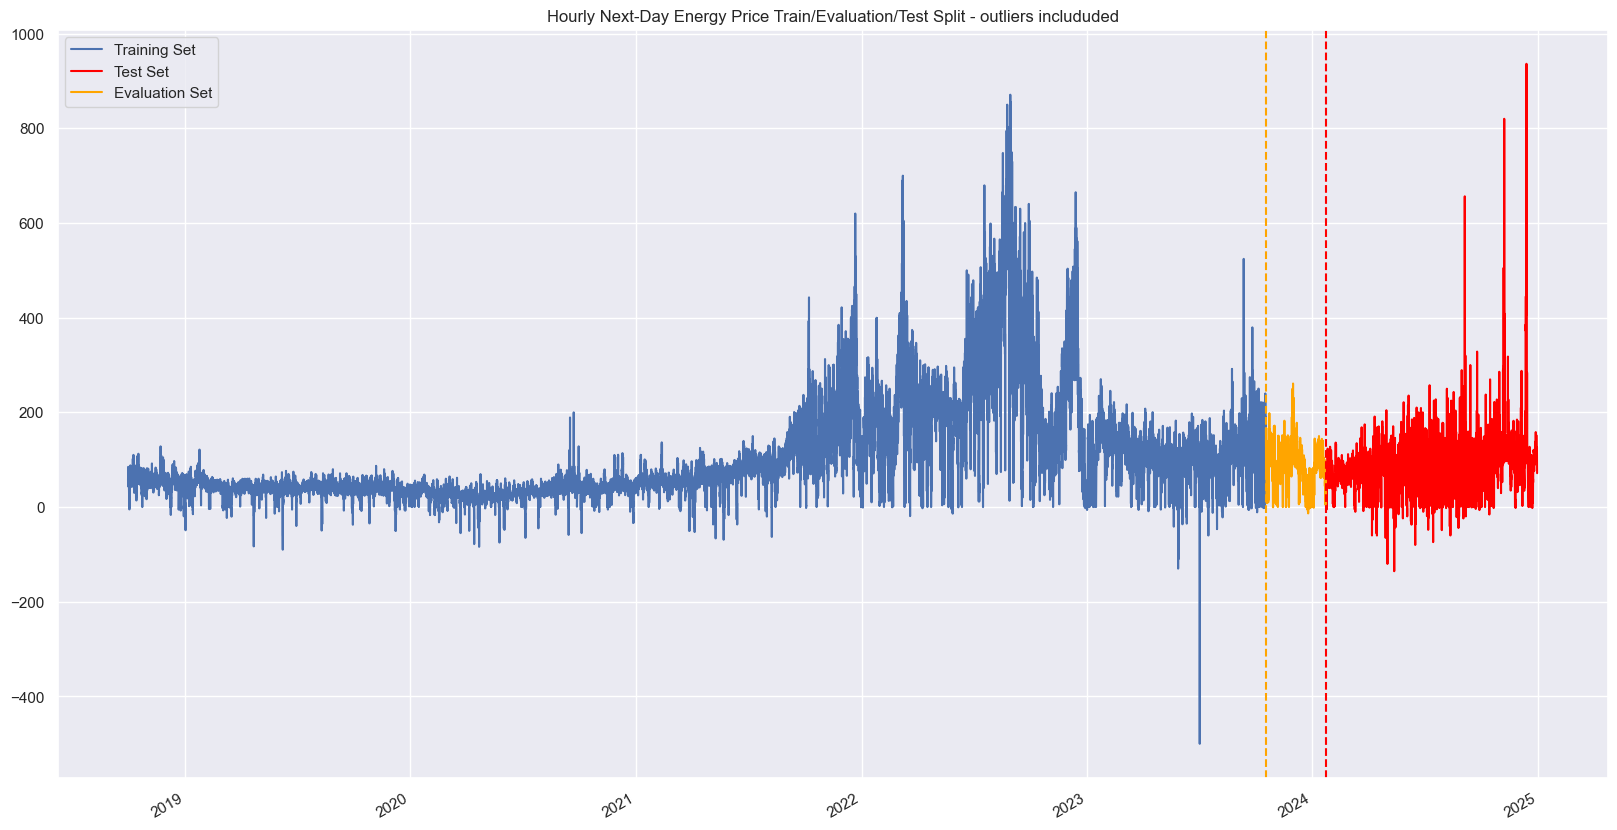

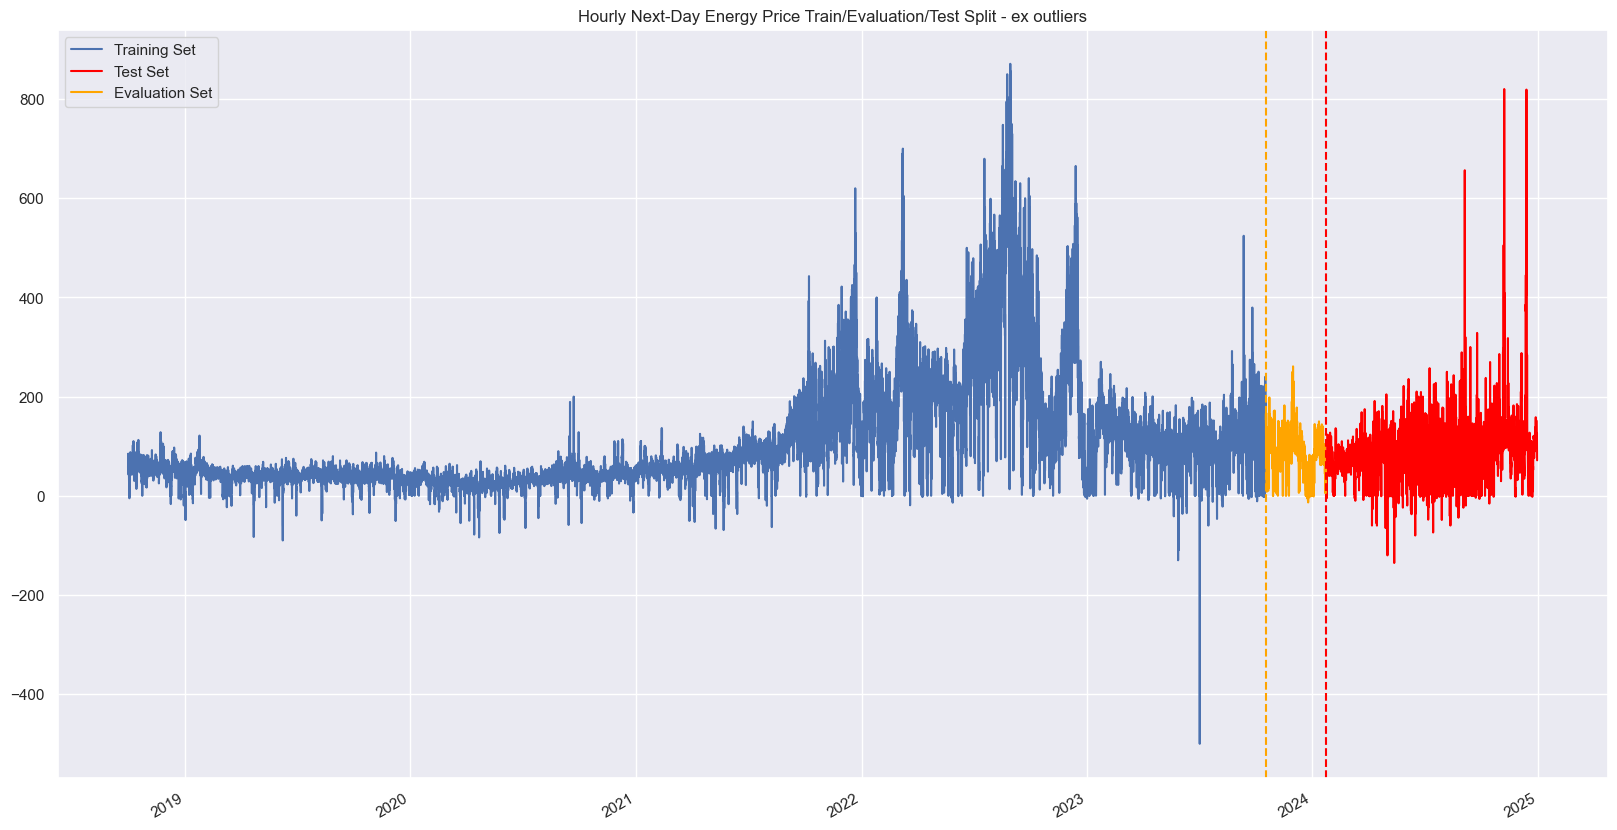

In [26]:
plot_price_split(train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST, "outliers includuded")
plot_price_split(train_XGB, eval_XGB, test_XGB, SPLIT_DATE_EVAL_INTERVAL, SPLIT_DATE_TEST_INTERVAL, "ex outliers")

## Prediction

### Linear Regression

In [27]:
lr_predictions  = linear_regression(X_train, y_train, X_test, y_test, scalar)
lr_predictions_interval = linear_regression(X_train_XGB, y_train_XGB, X_test_XGB, y_test_XGB, scalar)

### XGBoost

In [28]:
best_params = {
    "base_score": 0.380924762889507,
    "early_stopping_rounds": 215,
    "max_depth": 80,
    "learning_rate": 0.06,
    "n_estimators": 150,
    "gamma": 0.9,
    "min_child_weight": 6,
    "subsample": 0.5719023844219375,
    "colsample_bytree": 0.8815691043681952,
}
xgb_y_predicted_mse, xgb_mse = predict_mse(best_params, X_train_XGB, y_train_XGB, X_val_XGB, y_val_XGB, X_test_XGB)
xgb_y_predicted_mae, xgb_mae = predict_mae(best_params, X_train_XGB, y_train_XGB, X_val_XGB, y_val_XGB, X_test_XGB)


[0]	validation_0-rmse:86.93125
[25]	validation_0-rmse:19.03581
[50]	validation_0-rmse:5.53820
[75]	validation_0-rmse:3.65240
[100]	validation_0-rmse:3.49557
[125]	validation_0-rmse:3.51275
[149]	validation_0-rmse:3.51801
[0]	validation_0-mae:77.15091
[25]	validation_0-mae:16.72058
[50]	validation_0-mae:4.44977
[75]	validation_0-mae:2.57955
[100]	validation_0-mae:2.44519
[125]	validation_0-mae:2.46027
[149]	validation_0-mae:2.47104


### Prophet

In [29]:
# Initialize Prophet model
model = Prophet(
    changepoint_prior_scale = 0.5,
    seasonality_prior_scale = 1.0,
    holidays_prior_scale = 1.0,
    seasonality_mode= 'multiplicative'
)

#Add fourier order for weekly and monthly seasonality
model.add_seasonality(name='weekly', period=7, fourier_order=20)
model.add_seasonality(name='monthly', period=30.5, fourier_order=20)
model.add_seasonality(name='yearly', period=365, fourier_order=20)

# Add time-based regressors

for feature in FEATURES:
     model.add_regressor(feature)
     
train_data = train.rename(columns={"Price": "y"}).reset_index().rename(columns={"index": "ds"}).dropna()

model.fit(train_data)

test_data_prophet = test.copy().reset_index().rename(columns={"index": "ds"}).dropna()
test_data_prophet.drop(columns=["Price"])
prophet_predictions = model.predict(test_data_prophet)["yhat"]


## Results

### Errors

In [30]:
for fet in FEATURES:
    if fet in [ "ma_3_hours_pumped_storage_generation", "ma_6_hours_pumped_storage_generation","Biomass","Hard Coal","Hydro","Lignite","Natural Gas","Nuclear","Other","Pumped storage generation","Solar","Wind offshore","Wind onshore"]:
        print(fet) 

calculate_error_metrics(y_test, [lr_predictions, prophet_predictions, xgb_y_predicted_mse])

### Plots

In [31]:
predictions = [(prophet_predictions, "Prophet", "MSE"), (xgb_y_predicted_mse, "XGBoost","MSE"), (xgb_y_predicted_mae, "XGBoost","MAE"), (lr_predictions, "Linear Regression","MSE")]

plot_predicted(y_test, predictions, prediction_date_picker.value)

### XGBoost - Feature Importance

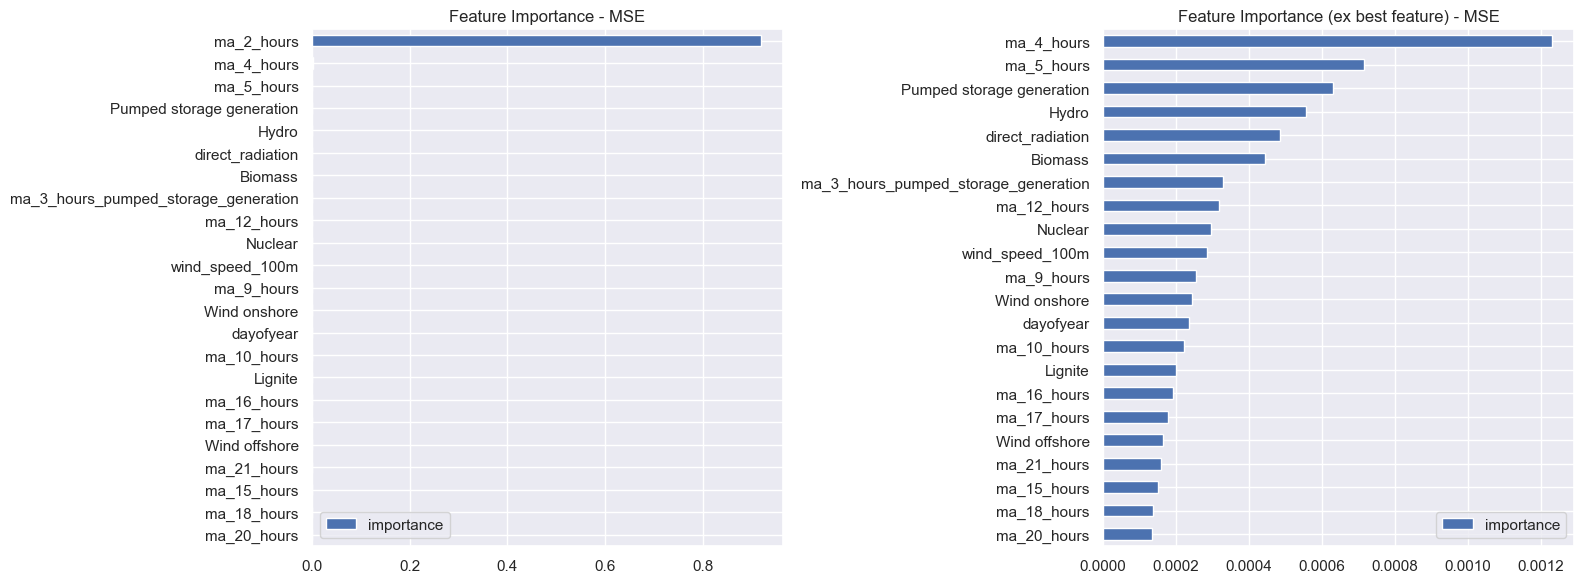

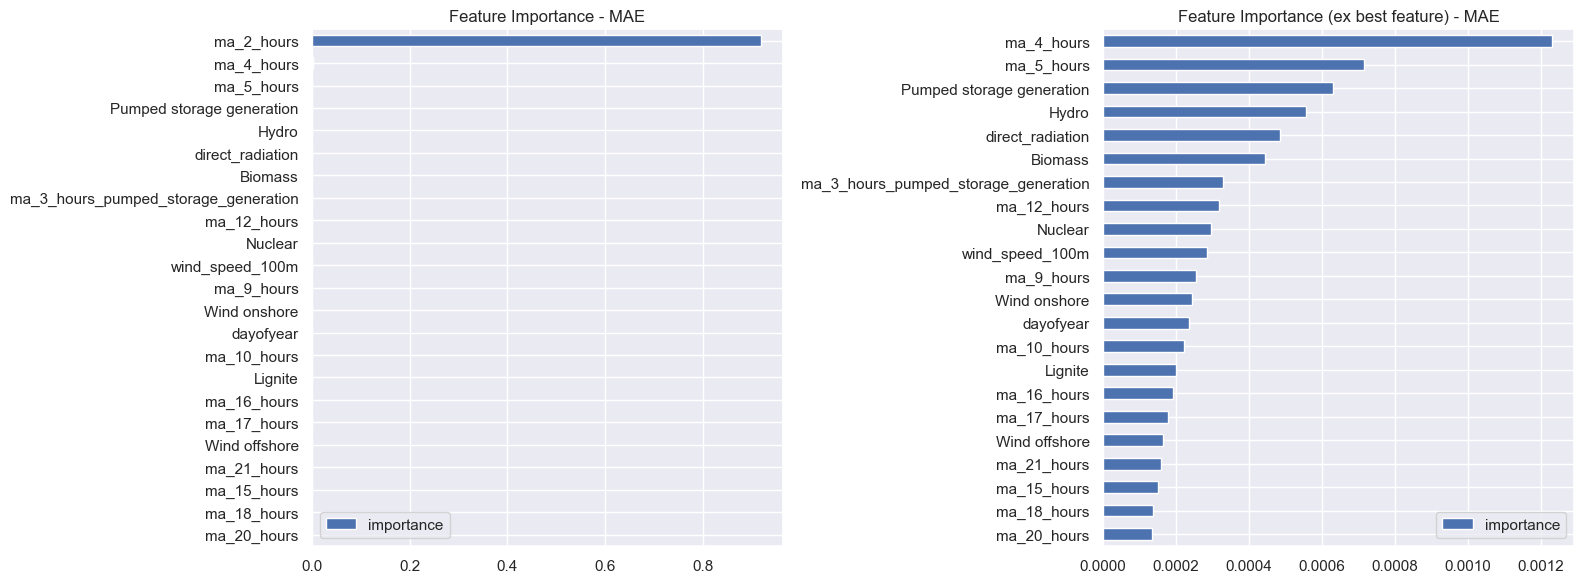

In [32]:
feature_importance(xgb_mse, "MSE")
feature_importance(xgb_mae, "MAE")

## Prediction

In [ ]:
# def append_pred_values(df):


last_month = 24 * 31
window = 24
benchmarking_set = combined_df.iloc[-last_month:].copy()
cols = ["Price", "Hydro", "Pumped storage generation","Solar","Wind offshore","Wind onshore","temperature_2m","precipitation","wind_speed_100m","direct_radiation"]
FINAL_FEATURES =  ["hour",
        "dayofyear",
        "dayofweek",
        "ma_2_hours",
        "ma_3_hours",
        "ma_4_hours",
        "ma_5_hours",
        "ma_6_hours",
        "ma_7_hours",
        "ma_8_hours",
        "ma_9_hours",
        "ma_10_hours",
        "ma_11_hours",
        "ma_12_hours",
        "ma_13_hours",
        "ma_14_hours",
        "ma_15_hours",
        "ma_16_hours",
        "ma_17_hours",
        "ma_18_hours",
        "ma_19_hours",
        "ma_20_hours",
        "ma_21_hours",
        "ma_22_hours",
        "ma_23_hours",
        "ma_1_days",
        "ma_3_days",
        "ma_7_days",
        # "Biomass",
        # "Hard Coal",
        "Hydro",
        # "Lignite",
        # "Natural Gas",
        # "Nuclear",
        # "Other",
        "Pumped storage generation",
        "ma_3_hours_pumped_storage_generation",
        "ma_6_hours_pumped_storage_generation",
        "Solar",
        "Wind offshore",
        "Wind onshore",
        "temperature_2m",
        "precipitation",
        "wind_speed_100m",
        "direct_radiation"]

window = 24

benchmark_df = merged_df.iloc[-last_month:][cols] # remainder of dataset for testing
test_df = merged_df[SPLIT_DATE_TEST:].iloc[:-last_month][cols]

w_test_df = test_df.copy()[:-window] # initially remove 24h (to be replaced with predictions and samples)
print(len(w_test_df))

for i in range(len(benchmarking_set) - window):
    y_t = benchmarking_set.iloc[i:i+window]["Price"] # use 24h at a time 
    last_date = w_test_df.index[-1]
    extended_test_df = extend_by_predictions_and_samples(w_test_df, last_date)

    print(y_t)
    print(extended_test_df)

    # XGBoost

    # Prophet

#     test_data_prophet = test.copy().reset_index().rename(columns={"index": "ds"}).dropna()
#     test_data_prophet.drop(columns=["Price"])
#     prophet_predictions = model.predict(test_data_prophet)["yhat"]


    # Linear Regression
    






    break
    
    

    # prophet_predictions = model.predict(test_data_prophet)["yhat"]


8190
Last 2024-12-28 23:00:00
24 estimations added to Price column.
Fetching predicted energy mix
                     Wind onshore  Wind offshore  Solar
Datetime                                               
2024-12-29 23:00:00       4824.75        22992.5    0.0
24
8214
